The ultimate objective of this portion of the hack it to create Metric Analysis Framework metrics to determine the value of a given opsim run for the intermediate mass MACHO science. 

Note that to run this notebook you will need to have installed MAF. Follow the directions at:

https://github.com/wadawson/sims_maf_contrib/blob/master/tutorials/Index.ipynb

To run this notebook you should have,

> setup sims_maf

within the terminal where you ran ipython, i.e.

>ipython notebook IntroductionNotebook.ipynb

In this directory you should have downloaded the survey simulation database 

>wget http://ops2.lsst.org/runs/reference_run/minion_1016/minion_1016_sqlite.db.gz
> gzip -d minion_1016_sqlite.db.gz

It may also be helpful to look at 

https://github.com/wadawson/sims_maf_contrib/blob/master/tutorials/Introduction%20Notebook.ipynb

before getting started on this notebook, since this notebook will skip some of the pedantic expositions.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# import lsst sims maf modules
import lsst.sims.maf
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

%matplotlib inline

## General Input
### Catalog

In [7]:
opsdb = db.OpsimDatabase('./minion_1016_sqlite.db')
outDir = 'notebook_output'

### SQL Query

In [18]:
# Initially let's just look at the number of observations in r-band after 2 years with default kwargs
sql = 'filter="r" and night < %i' % (365.25*10)

### Metrics

In [19]:
# Calculate the median gap between consecutive observations within a night, in hours.
metric_intranightgap = metrics.IntraNightGapsMetric(reduceFunc=np.median)

# Calculate the median gap between consecutive observations between nights, in days.
metric_internightgap = metrics.InterNightGapsMetric(reduceFunc=np.median)

# Uniformity of time between consecutive visits on short time scales:
'''
timeCol : str, optional
    The column containing the 'time' value. Default expMJD.
minNvisits : int, optional
    The minimum number of visits required within the time interval (dTmin to dTmax).
    Default 100.
dTmin : float, optional
    The minimum dTime to consider (in days). Default 40 seconds.
dTmax : float, optional
    The maximum dTime to consider (in days). Default 30 minutes.
'''
metric_rapidrevisit = metrics.RapidRevisitMetric(timeCol='expMJD', minNvisits=10,
                 dTmin=40.0 / 60.0 / 60.0 / 24.0, dTmax=30.0 / 60.0 / 24.0)

# Number of revisits with time spacing less than 24 hours
metric_nrevisit24hr = metrics.NRevisitsMetric(dT=24*60)

### Slicer
Let's look at the MAF results in the galactic coordinate system since this correlates nicely with stellar number density. (More stars, more expected number of microlensing events.)

In [20]:
# Let's look at the metric results in the galactic coordinate fram
slicer = slicers.HealpixSlicer(latCol='galb', lonCol='gall')

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


### Plot functions and customization

In [32]:
#plotFuncs = [plots.HealpixSkyMap()] # only plot the sky maps for now
# Customize the plot format
plotDict_intranightgap = {'colorMin':0, 'colorMax': 1., 'cbarFormat': '%0.2f'}  # Set the max on the color bar
plotDict_internightgap = {'colorMin':0,'colorMax': 10.}  # Set the max on the color bar
plotDict_rapidrevisit = {'cbarFormat': '%0.2f'}
plotDict_nrevisit24hr = {'colorMin':0,'colorMax': 300.}

### Bundles

In [33]:
# Create the MAF bundles for each plot
bundle_intranightgap = metricBundles.MetricBundle(metric_intranightgap, slicer, sql, plotDict=plotDict_intranightgap)#, plotFuncs=plotFuncs)
bundle_internightgap = metricBundles.MetricBundle(metric_internightgap, slicer, sql, plotDict=plotDict_internightgap)#, plotFuncs=plotFuncs)
bundle_rapidrevisit = metricBundles.MetricBundle(metric_rapidrevisit, slicer, sql, plotDict=plotDict_rapidrevisit)#, plotFuncs=plotFuncs)
bundle_nrevisit24hr = metricBundles.MetricBundle(metric_nrevisit24hr, slicer, sql, plotDict=plotDict_nrevisit24hr)#, plotFuncs=plotFuncs)
# Create the query bundle dictonary to run all of the queries in the same run
bdict = {'intragap':bundle_intranightgap, 'intergap':bundle_internightgap,
         'rapidrevisit':bundle_rapidrevisit, 'nrevisit24hr':bundle_nrevisit24hr}
bg = metricBundles.MetricBundleGroup(bdict, opsdb, outDir=outDir)

In [34]:
# Run the queries
bg.runAll()

Querying database with constraint filter="r" and night < 3652
Found 538713 visits
Running:  ['intergap', 'intragap', 'rapidrevisit', 'nrevisit24hr']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with filter="r" and night < 3652 constraint now.
monopole: 12.8928  dipole: lon: -58.833, lat: -38.5906, amp: 3.62712


/Users/dawson29/anaconda/opt/lsst/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 234 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.368883  dipole: lon: 149.314, lat: 15.8804, amp: 0.0457072
monopole: 0.334553  dipole: lon: -61.8646, lat: -34.2528, amp: 0.0513457


/Users/dawson29/anaconda/opt/lsst/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 1784 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 121.532  dipole: lon: -139.001, lat: -85.6261, amp: 11.9718
Plotting complete.


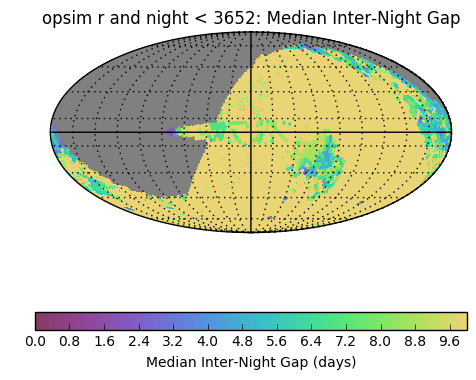

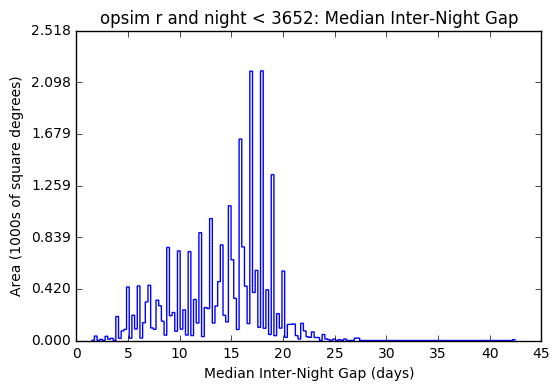

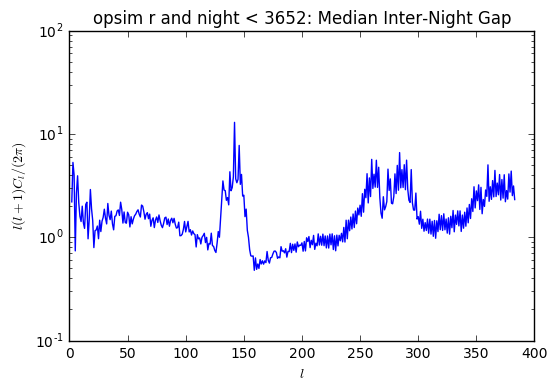

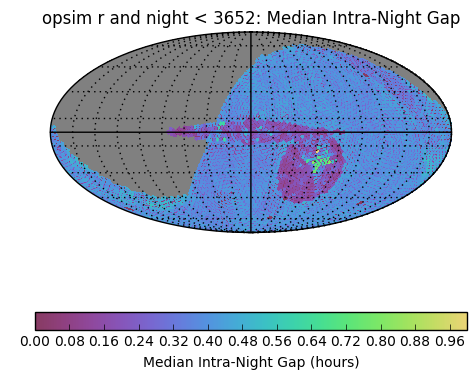

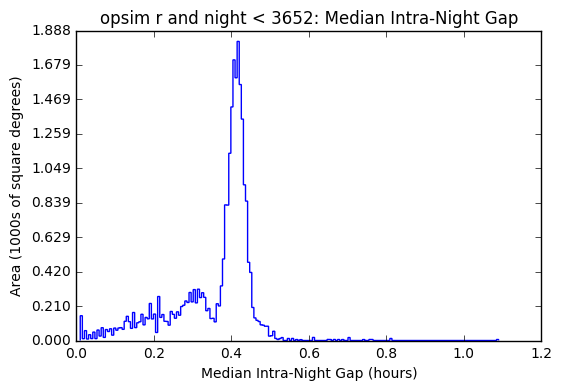

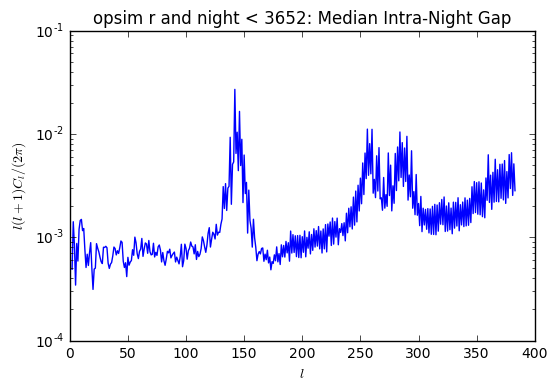

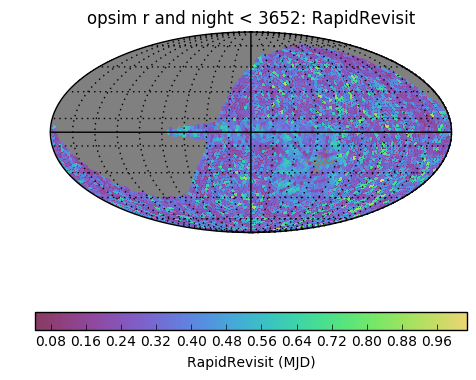

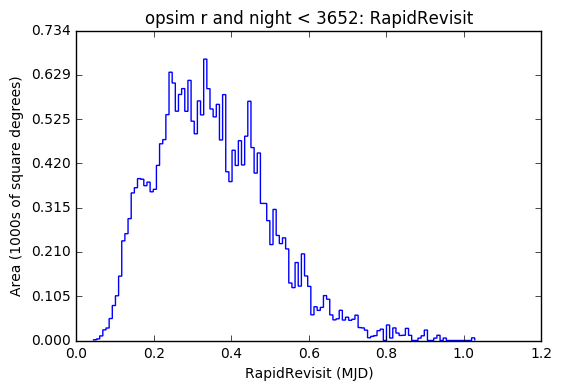

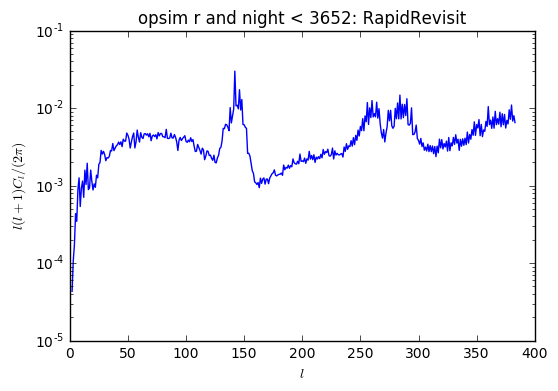

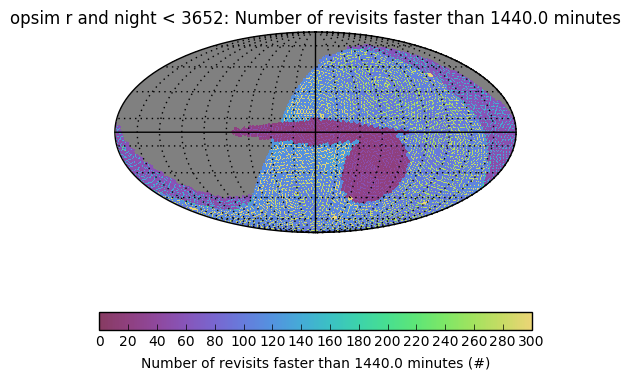

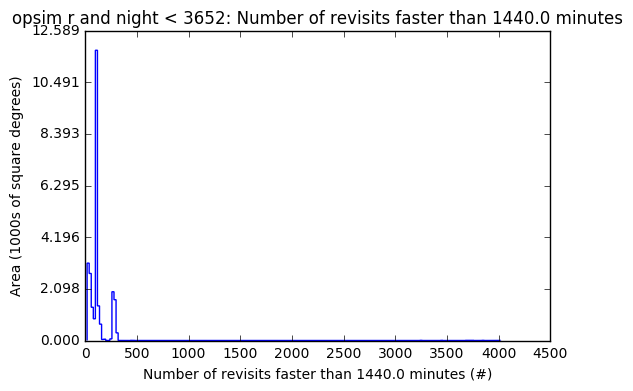

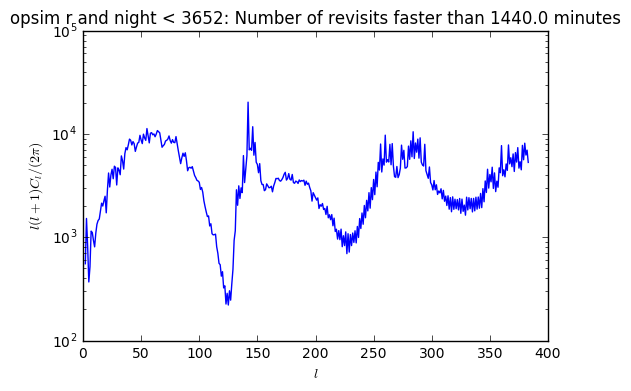

In [35]:
# Create the plots
bg.plotAll(closefigs=False)

## Plot a light curve
This is largely based on:
http://localhost:8888/notebooks/Git/sims_maf_contrib/tutorials/PullLightCurves.ipynb

In [42]:
outDir ='LightCurve'
dbFile = 'minion_1016_sqlite.db'
resultsDb = db.ResultsDb(outDir=outDir)

In [37]:
filters = ['u','g','r','i','z','y']
colors={'u':'cyan','g':'g','r':'y','i':'r','z':'m', 'y':'k'}

In [49]:
# Set RA, Dec for a single point in the sky. in radians. Galactic Center.
ra = np.radians(266.4168)
dec = np.radians(-29.00)
# SNR limit (Don't use points below this limit)
snrLimit = 5.
# Demand this many points above SNR limit before plotting LC
nPtsLimit = 6

In [51]:
# The pass metric just passes data straight through.
metric = metrics.PassMetric(cols=['filter','fiveSigmaDepth','expMJD'])
slicer = slicers.UserPointsSlicer(ra,dec,lonCol='ditheredRA',latCol='ditheredDec')
sql = ''
bundle = metricBundles.MetricBundle(metric,slicer,sql)
bg =  metricBundles.MetricBundleGroup({0:bundle}, opsdb,
                                      outDir=outDir, resultsDb=resultsDb)

In [52]:
bg.runAll()

Querying database with no constraint.
Found 2447931 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [53]:
bundle.metricValues.data[0]['filter']

array(['g', 'g', 'r', ..., 'i', 'u', 'u'], 
      dtype='|S256')

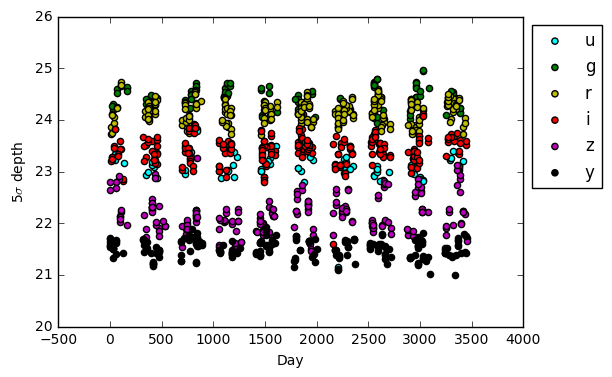

In [54]:
dayZero = bundle.metricValues.data[0]['expMJD'].min()
for fname in filters:
    good = np.where(bundle.metricValues.data[0]['filter'] == fname)
    plt.scatter(bundle.metricValues.data[0]['expMJD'][good]- dayZero, 
                bundle.metricValues.data[0]['fiveSigmaDepth'][good],
                c = colors[fname], label=fname)
plt.xlabel('Day')
plt.ylabel('5$\sigma$ depth')
plt.legend(scatterpoints=1, loc="upper left", bbox_to_anchor=(1,1))

Note that something doesn't seem right about the light curve above since there is >mag extinction towards the center of the Milky Way for bluer bands, yet these are the same 5sigma magnitude depths as towards the LMC (see below).

Note that we could take the 5 sigma depth and translate that into a photometric unertainty for a given magnitude magnification event.

### LMC Example

Querying database with no constraint.
Found 2447931 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


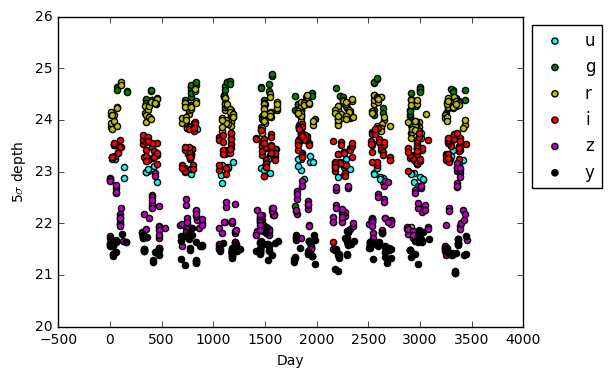

In [56]:
# Set RA, Dec for a single point in the sky. in radians. LMC.
ra = np.radians(80.8942)
dec = np.radians(-69.756)
# SNR limit (Don't use points below this limit)
snrLimit = 5.
# Demand this many points above SNR limit before plotting LC
nPtsLimit = 6
# The pass metric just passes data straight through.
metric = metrics.PassMetric(cols=['filter','fiveSigmaDepth','expMJD'])
slicer = slicers.UserPointsSlicer(ra,dec,lonCol='ditheredRA',latCol='ditheredDec')
sql = ''
bundle = metricBundles.MetricBundle(metric,slicer,sql)
bg =  metricBundles.MetricBundleGroup({0:bundle}, opsdb,
                                      outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bundle.metricValues.data[0]['filter']
dayZero = bundle.metricValues.data[0]['expMJD'].min()
for fname in filters:
    good = np.where(bundle.metricValues.data[0]['filter'] == fname)
    plt.scatter(bundle.metricValues.data[0]['expMJD'][good]- dayZero, 
                bundle.metricValues.data[0]['fiveSigmaDepth'][good],
                c = colors[fname], label=fname)
plt.xlabel('Day')
plt.ylabel('5$\sigma$ depth')
plt.legend(scatterpoints=1, loc="upper left", bbox_to_anchor=(1,1))